# Station Outlier Filter
## QC protocol for Private Weather Stations

This notebook presents how to use the 'Station Outlier filter' in the Python package `pypwsqc`, a quality assurance protocol developed for automated private weather stations (PWS). 

The package is based on the original R code available at https://github.com/LottedeVos/PWSQC/.

[Publication: de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. Geophysical Research Letters, 46(15), 8820-8829](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731)

`pypwsqc` depends on the `poligrain`, `xarray`, `pandas` and `numpy` packages. Make sure to install and import the required packages first.

In [1]:
import poligrain as plg
import xarray as xr

import pypwsqc

## Download example data

In this example, we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset. By running the cell below, an example NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [2]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5687k  100 5687k    0     0  4506k      0  0:00:01 --:--:--  0:00:01 4506k 5045k      0  0:00:01  0:00:01 --:--:-- 5967k


## Data preparations

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

We now load the data set under the name  `ds_pws`.

In [3]:
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data.nc")

We then slice the time series to 5 weeks of data to shorten the computation period of the example.

In [4]:
ds_pws = ds_pws.sel(time=slice("2017-07-01", "2017-07-30"))
ds_pws

<xarray.Dataset>
Dimensions:    (time: 8640, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-30T23:55:00
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 ...
    longitude  (id) float64 ...
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Reproject coordinates 

First we reproject the coordinates to a local metric coordinate reference system to allow for distance calculations. In the Amsterdam example we use EPSG:25832. **Remember to use a local metric reference system for your use case!** We use the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

### Create distance matrix

Then, we calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [6]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Select range for neighbouring checks

The quality control is performed by comparing time series of each station with the time series of neighbouring stations within a specificed range `max_distance`. The selected range depends on the use case and area of interest. In this example, we use 10'000 meters. `max_distance` is called `d` in the [original publication](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731).

### Select considered range around each station

In [7]:
max_distance = 10e3

## Quality control

Now the data set is prepared to run the quality control.

### Station Outlier filter

Conditions for raising Station Outlier flag:

* Median of the rolling pearson correlation with all neighboring stations within range `max_distance` is less than threshold `gamma`
* Filter cannot be applied if less than `n_stat` neighbours are reporting data (SO flag is set to -1)
*  Filter cannot be applied if there are less than `n_stat` neighbours with less than `mmatch` intervals overlapping with the evaluated station (SO flag is set to -1)

For settings for parameter `evaluation_period`, `mmatch`, `gamma`, and `n_stat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731 

Note! The SO-filter is different compared with the original R-code. In its original implementation, any interval with at least `mrain` intervals of nonzero rainfall measurements is evaluated. In this implementation, only a fixed rolling time window is evaluated. Therefore, the `mrain` variable from the orignal code is not needed. In the original publication, the variable `evaluation_period` (the evaluation period) is set to 4032. For 5-minute data, this is equivalent of two weeks. When the option of a variable evaluation period is excluded, two weeks is often too short as there might not be enough wet periods in the last two weeks to calculate the correlation. This results in a lot of '-1'-flags (filter cannot be applied). It is suggested to use a longer evaluation period, for example four weeks (`evaluation_period` = 8064 for 5-minute data).

The first `evaluation_period` timesteps (here set to 8064 time steps), the rollig median correlation is computed with the last time steps in the time series. Therefore, the resulting `median_corr_nbrs` should be disregarded the first `evaluation_period` time steps.

`evaluation_period` is called `mint`in the original publication.

We initialize data variables for the resulting SO-flags and the median pearson correlation with neighboring stations with the value -999. If the variables have the value 0 (passed the test), 1 (did not pass the test) or -1 (not enough information) after running the SO-filter, we know that these time series have been evaluated. If the value is still -999, this means that something went wrong as the data has not been processed. 

We also save the threshold `gamma` as a variable. In this way we can easily visualize if the median correlation with neighbors drops below this threshold, which is the condition for raising a SO-flag.

#### Set SO parameters

In [8]:
evaluation_period = 8064
mmatch = 200
gamma = 0.15
n_stat = 5

#### Set bias correction parameters (optional)

If the variable `bias_corr` is set to True (default: False), a bias correction factor will be calculated per time step over a rolling window of length `evaluation_period` time steps - the same window length applied to calculate the SO flags. The bias correction can also be calculated separately using the bias correction notebook. The default is to use the median rainfall of the neighboring stations as reference. To use another data source as reference, that data must be added as a variable named `reference` to the xarray data set. [Here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb) you can find an example of how to construct an xarray data set. 

In [9]:
bias_corr = True  # default False
beta = 0.2
dbc = 1

#### Run SO filter

In [ ]:
# Loading the data into memory can speed up the so_filter a lot
ds_pws = ds_pws.load()

In [11]:
%%time

ds_pws_flagged = pypwsqc.flagging.so_filter(
    ds_pws,
    evaluation_period,
    mmatch,
    gamma,
    n_stat,
    distance_matrix,
    max_distance,
    bias_corr=True,
    beta=beta,
    dbc=dbc,
)

CPU times: user 11.5 s, sys: 3.89 s, total: 15.4 s
Wall time: 15.4 s


### Save flagged dataset

In [12]:
ds_pws_flagged.to_netcdf("so_flagged_dataset.nc")

In [59]:
ds_test = xr.open_dataset("../../tests/test_dataset.nc").load()
ds_test = ds_test.sel(time=slice("2017-08-29", "2017-10-01"))

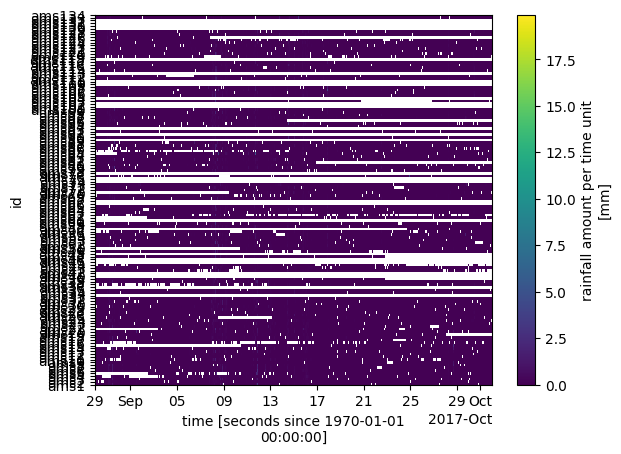

In [60]:
ds_test.rainfall.plot()

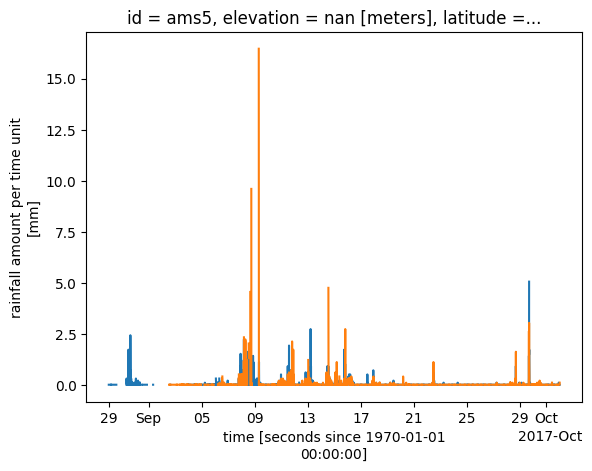

In [61]:
ds_test.sel(id="ams4").rainfall.plot()
ds_test.sel(id="ams5").rainfall.plot()

In [63]:
ds_test.id.data[ds_test.rainfall.isel(time=0).isnull()]

array(['ams5', 'ams15', 'ams21', 'ams23', 'ams33', 'ams36', 'ams37',
       'ams40', 'ams41', 'ams44', 'ams45', 'ams46', 'ams48', 'ams50',
       'ams56', 'ams57', 'ams60', 'ams61', 'ams66', 'ams67', 'ams70',
       'ams74', 'ams75', 'ams77', 'ams84', 'ams85', 'ams89', 'ams91',
       'ams93', 'ams101', 'ams102', 'ams104', 'ams109', 'ams110',
       'ams113', 'ams118', 'ams129', 'ams130', 'ams131', 'ams132'],
      dtype='<U6')

In [64]:
result = pypwsqc.flagging.so_filter(
    ds_pws=ds_test,
    distance_matrix=distance_matrix,
    evaluation_period=evaluation_period,
    mmatch=200,
    gamma=0.15,
    n_stat=5,
    max_distance=10e3,
    bias_corr=True,
    beta=0.2,
    dbc=1,
)

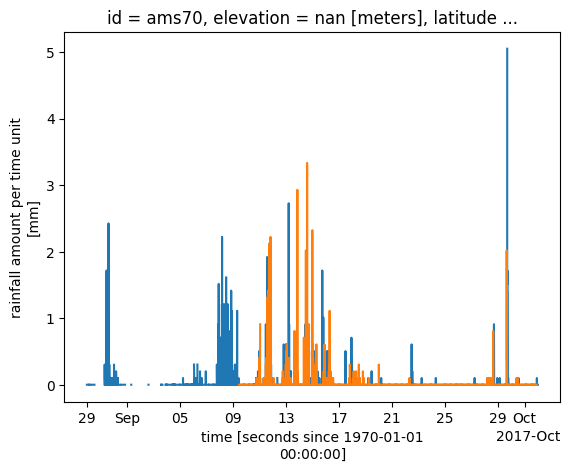

In [76]:
result.sel(id="ams4").rainfall.plot()
result.sel(id="ams70").rainfall.plot()

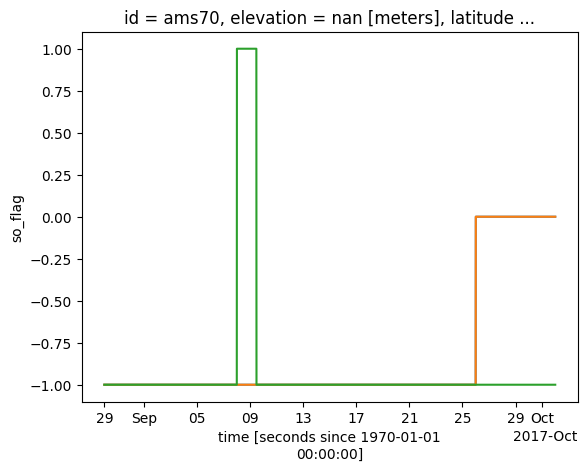

In [79]:
result.sel(id="ams3").so_flag.plot()
result.sel(id="ams4").so_flag.plot()
result.sel(id="ams70").so_flag.plot()

In [81]:
(result.sel(id="ams70", time="2017-09-09").so_flag.data[:10],)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),)